In [185]:
from __future__ import print_function, division
import os
import os.path
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw, ImageFont
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon, shape, Point, Polygon, LineString
import re
import cv2

In [2]:
!pwd

/Users/shimash/experiments/notebooks


In [3]:
ls

data_visualizer.ipynb  dataset.ipynb


In [4]:
#cd SAR-Intensity

In [5]:
#list_of_files = [f for f in os.listdir() if os.path.isfile(f)]
#print(list_of_files[0])

In [6]:
cd ../..

/Users/shimash


### Load Building Footprints

In [7]:
data = pd.read_csv('data/train/AOI_11_Rotterdam/SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv')

In [166]:
print(data.shape)

(214682, 6)


In [187]:
data.head()

,ImageId,TileBuildingId,PolygonWKT_Pix,Mean_Building_Height,Median_Building_Height,StdDev_Building_Height
0,20190822070610_20190822070846_tile_3721,0,"POLYGON ((299.6396801332012 349.3765436094254,...",9.962397,9.96,0.006495
1,20190822070610_20190822070846_tile_3721,1,"POLYGON ((115.5360228798818 339.845588516444, ...",2.810000,2.81,0.000000
2,20190822070610_20190822070846_tile_3721,2,"POLYGON ((768.9086768317502 329.8960437048227,...",14.420000,14.42,0.000000
3,20190822070610_20190822070846_tile_3721,3,"POLYGON ((755.8174585120287 330.0953964963555,...",14.420000,14.42,0.000000
4,20190822070610_20190822070846_tile_3721,4,"POLYGON ((392.8786215754226 335.6222213506699,...",8.590000,8.59,0.000000


In [10]:
data.keys()

Index(['ImageId', 'TileBuildingId', 'PolygonWKT_Pix', 'Mean_Building_Height',
       'Median_Building_Height', 'StdDev_Building_Height'],
      dtype='object')

In [11]:
pointer = 0
poly_index_list = []
while pointer < len(data):
    start = pointer
    end = pointer
    tile_number_st = data['ImageId'][pointer].rfind('_')
    tile_number = data['ImageId'][pointer][tile_number_st+1:]
    while (pointer+2) < len(data) and (data['TileBuildingId'][pointer] < data['TileBuildingId'][pointer+1]):
        end +=1
        pointer +=1
    poly_index_list.append([tile_number, start, end, data['ImageId'][pointer]])
    pointer +=1
#print(poly_index_list[-1])

### SAR-Intensity Visualization
Tiled geotiffs of 4-Band Quad-Polarized (HH, HV, VH, VV) raster data displaying intensity of backscatter in decibels from Capella’s aerial collect.   

- This is the only type of data which is available for test.

In [12]:
import rasterio as rio
from matplotlib import pyplot as plt
from rasterio.plot import show

In [196]:
PATH = 'data/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_'+'20190822070610_20190822070846_tile_3721' + '.tif'

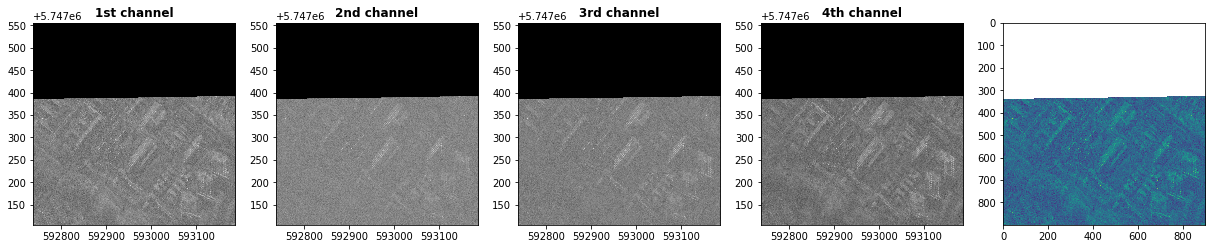

In [201]:
with rio.open(PATH) as lidar_dem:
    lidar_dem.bounds
#     test_1 = lidar_dem.read(1)
#     print(test_1[890][100])
    fig, (axr, axg, axb, axp, img) = plt.subplots(1,5, figsize=(21,7))
    show((lidar_dem, 1), ax=axr, cmap='gray', title='1st channel')
    show((lidar_dem, 2), ax=axg, cmap='gray', title='2nd channel')
    show((lidar_dem, 3), ax=axb, cmap='gray', title='3rd channel')
    show((lidar_dem, 4), ax=axp, cmap='gray', title='4th channel')
    show(lidar_dem, ax=img)
#     show(lidar_dem.read(2), transform=lidar_dem.transform)

In [15]:
lidar_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 900,
 'height': 900,
 'count': 4,
 'crs': CRS({'init': 'epsg:32631'}),
 'transform': (592736.9762427969, 0.5, 0.0, 5747555.521581902, 0.0, -0.5),
 'affine': Affine(0.5, 0.0, 592736.9762427969,
        0.0, -0.5, 5747555.521581902)}

### PS-RGB
Tiled 8-bit color-corrected geotiffs of RGB raster data from Maxar WorldView-2 pan-sharpened to 0.5m.

In [16]:
!pwd

/Users/shimash


In [17]:
list_of_files_RGB = [f for f in os.listdir() if os.path.isfile(f)]
print(list_of_files_RGB[0])

.DS_Store


In [18]:
tile_numbers = []
for ind in range(len(list_of_files_RGB)):
    head, tail = os.path.split(list_of_files_RGB[ind])
    tile_number_st = list_of_files_RGB[ind].rfind('_')
    tile_number = list_of_files_RGB[ind][tile_number_st+1:]
    tile_numbers.append(tile_number)

(900, 900, 3)


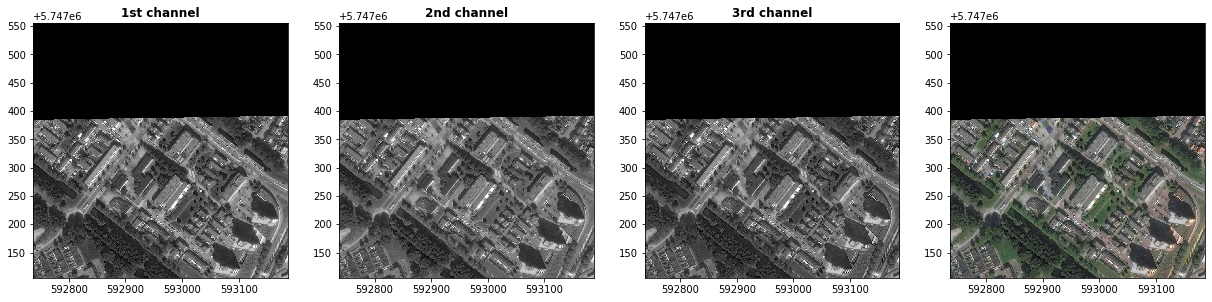

In [121]:
PATH_RGB = "data/train/AOI_11_Rotterdam/PS-RGB/" + "SN6_Train_AOI_11_Rotterdam" + "_PS-RGB_" + "20190822070610_20190822070846_tile_3721.tif"
with rio.open(PATH_RGB) as lidar_dem:
    data_RGB = np.zeros((900,900,3))
    data_RGB[:,:,0] = lidar_dem.read(1)
    data_RGB[:,:,1] = lidar_dem.read(2)
    data_RGB[:,:,2] = lidar_dem.read(3)
    print(data_RGB.shape)
    
    data_frame = lidar_dem
    lidar_dem.bounds
    
    lidar_dem_mask = lidar_dem.dataset_mask()
    
    fig, (axr, axg, axb, img) = plt.subplots(1,4, figsize=(21,7))
    show((lidar_dem, 1), ax=axr, cmap='gray', title='1st channel')
    show((lidar_dem, 2), ax=axg, cmap='gray', title='2nd channel')
    show((lidar_dem, 3), ax=axb, cmap='gray', title='3rd channel')
    show(lidar_dem, ax = img)

### PS-MS 
Tiled geotiffs of 4-Band Multi-Spectral raster data pan-sharpened to 0.5m from Maxar WorldView2
- Only available for training!

In [20]:
!pwd

/Users/shimash


In [21]:
img_sharpened =  "data/train/AOI_11_Rotterdam/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190822070610_20190822070846_tile_3721.tif"

uint16 1542


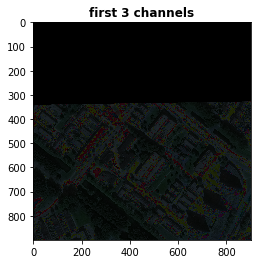

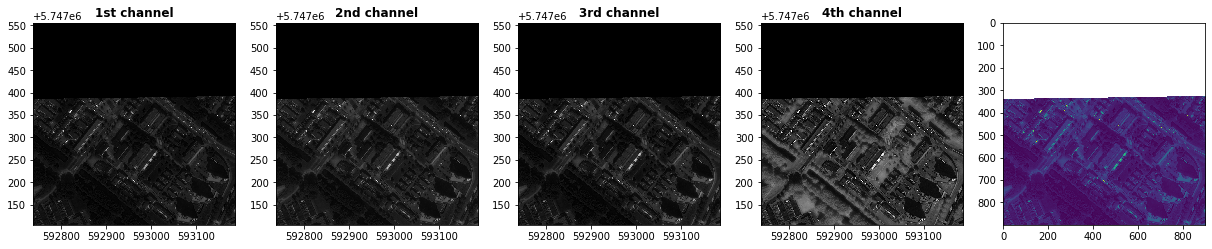

In [22]:
with rio.open(img_sharpened) as sar_sharpened:
    sar_sharpened.bounds
    
    image = sar_sharpened.read([1,2,3])
    print(image.dtype, np.max(image))
    image = (255 * image / np.max(image)).astype(np.uint16)
    show(image, title='first 3 channels')

    sar_sharpened_mask = sar_sharpened.dataset_mask()
    
    fig, (axr, axg, axb, axp, img) = plt.subplots(1,5, figsize=(21,14))
    show((sar_sharpened, 1), ax=axr, cmap='gray', title='1st channel')
    show((sar_sharpened, 2), ax=axg, cmap='gray', title='2nd channel')
    show((sar_sharpened, 3), ax=axb, cmap='gray', title='3rd channel')
    show((sar_sharpened, 4), ax=axp, cmap='gray', title='4th channel')
    show(sar_sharpened, ax = img)


### MS

In [23]:
PATH_MS = "data/train/AOI_11_Rotterdam/RGBNIR/SN6_Train_AOI_11_Rotterdam_RGBNIR_20190822070610_20190822070846_tile_3721.tif"

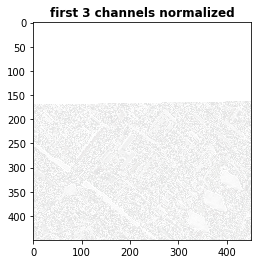

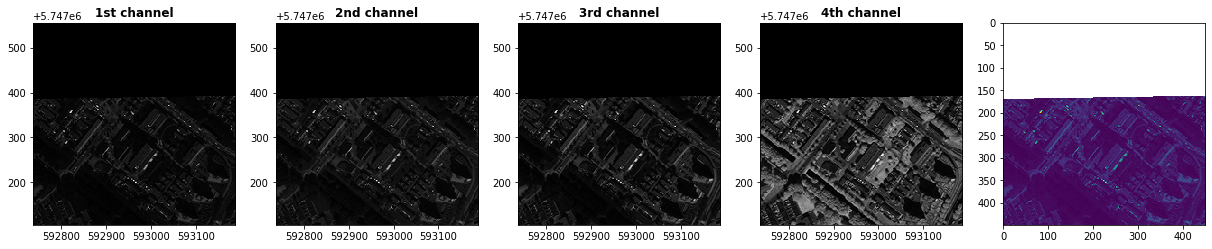

In [24]:
with rio.open(PATH_MS)as ms:
    image = ms.read()
    image = (255 * image / np.max(image)).astype(np.uint16)
    show(image, cmap='gray', title='first 3 channels normalized')

    ms_mask = ms.dataset_mask()
    
    fig, (axr, axg, axb, axn, img) = plt.subplots(1,5, figsize=(21,14))
    show((ms, 1), ax=axr, cmap='gray', title='1st channel')
    show((ms, 2), ax=axg, cmap='gray', title='2nd channel')
    show((ms, 3), ax=axb, cmap='gray', title='3rd channel')
    show((ms, 4), ax=axn, cmap='gray', title='4th channel')
    show(ms, ax = img)


### PAN

In [25]:
PATH_PAN = "data/train/AOI_11_Rotterdam/PAN/SN6_Train_AOI_11_Rotterdam_PAN_20190822070610_20190822070846_tile_3721.tif"

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS({'init': 'epsg:32631'}), 'transform': (592736.9762427969, 0.49999345509841014, 0.0, 5747555.521581902, 0.0, -0.49999345509841014), 'affine': Affine(0.49999345509841014, 0.0, 592736.9762427969,
       0.0, -0.49999345509841014, 5747555.521581902)}


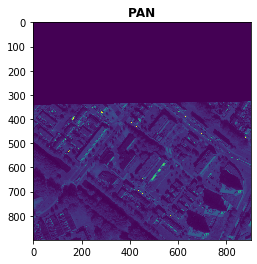

In [26]:
with rio.open(PATH_PAN) as pan:
    print(pan.meta)
    show(pan.read(), title = "PAN")

### Building Footprints GeoJSON

In [27]:
#load geojson
#import geojson
#from geojson import Polygon

In [28]:
PATH_GEOJSON = "data/train/AOI_11_Rotterdam/geojson_buildings/SN6_Train_AOI_11_Rotterdam_Buildings_20190822070610_20190822070846_tile_3721.geojson"

In [164]:
import json
with open(PATH_GEOJSON) as building:
    json_data = json.load(building)
    print(json_data.keys())
    print(json_data['features'][0]['geometry'])

dict_keys(['type', 'crs', 'features'])
{'type': 'Polygon', 'coordinates': [[[592886.7960828635, 5747380.833310097, 0.0], [592887.8157511643, 5747380.02952042, 0.0], [592889.7841743596, 5747378.479631942, 0.0], [592890.0932675151, 5747378.2356989365, 0.0], [592891.375752588, 5747377.2264696155, 0.0], [592888.8010094147, 5747373.903027412, 0.0], [592887.8058675122, 5747372.6180037465, 0.0], [592886.4668812398, 5747373.794429122, 0.0], [592882.7228492838, 5747369.341296791, 0.0], [592882.5061449747, 5747369.513239125, 0.0], [592882.6311255347, 5747369.667384441, 0.0], [592879.8687970384, 5747371.847416926, 0.0], [592879.0677987463, 5747372.480329071, 0.0], [592878.872668225, 5747372.634973968, 0.0], [592878.6714112354, 5747372.79341902, 0.0], [592877.8755729791, 5747373.421498995, 0.0], [592875.3309152315, 5747375.430621092, 0.0], [592872.7811302388, 5747377.443576103, 0.0], [592871.984259978, 5747378.072622488, 0.0], [592871.7840349961, 5747378.230101098, 0.0], [592871.5827780071, 574737

### One Sample from json file

[{'type': 'Feature', 'properties': {'roof_075mean': 9.96239667293454, 'roof_075median': 9.960000038146973, 'roof_075stdev': 0.006495201992984292, 'Building_ID': 15568, 'origarea': 423.61888917307067, 'origlen': 0, 'partialDec': 1.0, 'truncated': 0}, 'geometry': {'type': 'Polygon', 'coordinates': [[[592886.7960828635, 5747380.833310097, 0.0], [592887.8157511643, 5747380.02952042, 0.0], [592889.7841743596, 5747378.479631942, 0.0], [592890.0932675151, 5747378.2356989365, 0.0], [592891.375752588, 5747377.2264696155, 0.0], [592888.8010094147, 5747373.903027412, 0.0], [592887.8058675122, 5747372.6180037465, 0.0], [592886.4668812398, 5747373.794429122, 0.0], [592882.7228492838, 5747369.341296791, 0.0], [592882.5061449747, 5747369.513239125, 0.0], [592882.6311255347, 5747369.667384441, 0.0], [592879.8687970384, 5747371.847416926, 0.0], [592879.0677987463, 5747372.480329071, 0.0], [592878.872668225, 5747372.634973968, 0.0], [592878.6714112354, 5747372.79341902, 0.0], [592877.8755729791, 5747373.421498995, 0.0], [592875.3309152315, 5747375.430621092, 0.0], [592872.7811302388, 5747377.443576103, 0.0], [592871.984259978, 5747378.072622488, 0.0], [592871.7840349961, 5747378.230101098, 0.0], [592871.5827780071, 5747378.388546148, 0.0], [592870.785907747, 5747379.017592525, 0.0], [592868.2700150587, 5747381.003651287, 0.0], [592865.7582176153, 5747382.986843505, 0.0], [592864.9562201091, 5747383.619722803, 0.0], [592864.7621215963, 5747383.773401256, 0.0], [592864.560831821, 5747383.932845513, 0.0], [592863.7588343156, 5747384.565724805, 0.0], [592861.2264950976, 5747386.565247965, 0.0], [592861.169397004, 5747386.610308299, 0.0], [592879.1130236991, 5747386.883553463, 0.0], [592879.7232900724, 5747386.402949315, 0.0], [592880.7429255826, 5747385.60015889, 0.0], [592882.3622368473, 5747384.324899827, 0.0], [592884.6787727397, 5747382.500349272, 0.0], [592885.6984082528, 5747381.697558821, 0.0], [592885.8955700102, 5747381.541980278, 0.0], [592886.7960828635, 5747380.833310097, 0.0]]]}}

In [188]:
from scipy import misc
from skimage import color, measure
from shapely.geometry import Polygon
import geojson

In [190]:
#test 
mask_img = Image.new('1', (900, 900), 0)
poly = ImageDraw.Draw(mask_img)
for i in range(110):
    row = data.loc[i,'PolygonWKT_Pix']
    expression = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row)
    tup = (float(expression[0]), float(expression[1]))
    for i in range(2,len(expression),2):
        temp = (float(expression[i]),float(expression[i+1]))
        tup = tup + temp
#     print(tup)
    poly.polygon(tup, outline =1, fill=1)
    
mask = np.array(mask_img)

newIm = Image.fromarray(mask)
newIm.show()

In [42]:
# print(len(expression))
# for i in range(0,len(expression),2):
#     test.append([float(expression[i]), float(expression[i+1])])
# polygan = Polygan(np.zeros((len(test), 2)))

/Users/shimash


How should I normalize the input data?
Should I find the max for the whole dataset and they apply normalization? or should I calculate for each image?

In [218]:
def draw_polygons(start, end, image_id, img):
    test = []
    image = Image.fromarray(img.astype(np.uint8))
    poly = ImageDraw.Draw(image)
    for i in range(start,end+1):
        row = data.loc[i,'PolygonWKT_Pix']
        expression = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row)
        tup = (float(expression[0]), float(expression[1]))
        for i in range(2,len(expression),2):
            temp = (float(expression[i]),float(expression[i+1]))
            tup = tup + temp
#         print(tup)
        poly.polygon(tup, outline ="red")
#         polygons = np.round(tup)    
#         polys = np.int32(polygons)
#         print(polys)
    image.show()

In [228]:
def create_RGB_data(image_id):
    create_RGB_path = "data/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam" + "_PS-RGB_" + image_id + ".tif"
    with rio.open(create_RGB_path) as lidar_dem:
        img = np.zeros((900,900,3))
        img[:,:,0] = lidar_dem.read(1)
        img[:,:,1] = lidar_dem.read(2)
        img[:,:,2] = lidar_dem.read(3)
    return img
def create_SAR_data(image_id):
    create_SAR_path = "data/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam" + "_SAR-Intensity_" + image_id + ".tif"
    with rio.open(create_SAR_path) as lidar_dem:
        img = np.zeros((900,900,3))
        img[:,:,0] = lidar_dem.read(1)
#         img[:,:,1] = lidar_dem.read(2)
        img[:,:,2] = lidar_dem.read(3)
        img[:,:,1] = lidar_dem.read(4)
    return img*255/np.max(img)

In [229]:
def plot_footprints(num):
    for index in range(num):
        image_RGB = create_RGB_data(poly_index_list[index][3])
        image_SAR = create_SAR_data(poly_index_list[index][3])
        draw_polygons(poly_index_list[index][1], poly_index_list[index][2], poly_index_list[index][3], image_RGB)
        draw_polygons(poly_index_list[index][1], poly_index_list[index][2], poly_index_list[index][3], image_SAR)

In [230]:
plot_footprints(5)

In [59]:
mask = np.zeros((900,900))
poly = []
polygons = []
img = Image.fromarray(data_RGB.astype(np.uint8))
poly = ImageDraw.Draw(image)
for i in range(110):
    row = data.loc[i,'PolygonWKT_Pix']
    expression = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row)
    tup = (float(expression[0]), float(expression[1]))
    for i in range(2,len(expression),2):
        temp = (float(expression[i]),float(expression[i+1]))
        tup = tup + temp
        #print(tup)
        poly.polygon(tup, outline ="red")
img.show()
 

In [65]:
image = Image.fromarray(data_RGB.astype(np.uint8))
poly = ImageDraw.Draw(image)
for i in range(110):
    row = data.loc[i,'PolygonWKT_Pix']
    expression = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row)
    tup = (float(expression[0]), float(expression[1]))
    for i in range(2,len(expression),2):
        temp = (float(expression[i]),float(expression[i+1]))
        tup = tup + temp
    poly.polygon(tup, outline ="red")
image.show()